In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
import h5py
from scipy.ndimage import gaussian_filter1d
from scipy.signal import windows
import json

To calculate analytical SNR:

The magnitude of signal is $m = H^{-1}f$ where $H = A^TN^{-1}A$ and $f = A^TN^{-1}d$.

We know from Maximum-Likelihood theory that $\big<\delta_m\delta_m^T \big> = H^{-1}$. Therefore, $\sigma_m = H^{-1/2}$.
In time-domain, we define SNR as: $SNR = \frac{m}{\sigma_m}$ where all quantities are properly normalized as given above. Therefore, $SNR = H^{-1/2}f = \frac{f}{\sqrt{(H)}}$ (The last equality follows if H is a scalar, which it is if we're only fitting a scaling parameter.)

The square of SNR is also equivalent to the _improvement_ in chisquare of our fit. $\Delta \chi^2 = -f^TH^{-1}f = \frac{-f^2}{H} $

## Combined SNR

We can add the squares of SNR to get combined SNR, because $\chi^2$ from two independent datasets can be added. Shown below:

$\chi^2_h = d_h^TN_h^{-1}d_h - SNR_h^2$

$\chi^2_l = d_l^TN_l^{-1}d_l - SNR_l^2$

h and l represent the two detectors.

$\chi^2_{total} = \chi^2_h + \chi^2_l = d_h^TN_h^{-1}d_h + d_l^TN_l^{-1}d_l - (SNR_l^2 + SNR_h^2)$

The last term on right hand side can be identified as the combined SNR.

## Fourier Transform convention used here is the same as LIGO tutorial
_Allen, B., Anderson, W. G., Brady, P. R., Brown, D. A., & Creighton, J. D. (2012). FINDCHIRP: An algorithm for detection of gravitational waves from inspiraling compact binaries. Physical Review D, 85(12), 122006._

$F[k] = dt \sum_{n=0}^{N-1} f[n] e^{-j2\pi k n/N}$

$f[t] = df \sum_{k=0}^{N-1} F[k] e^{j2\pi k n/N}$

N = 131072

sampling frequency fs = 4096

dt = 1/fs

df = 1/(N*dt) = fs/N

## Windows and whitening

A Tukey window has been used here, as it's recommended in the LIGO paper. Tukey window also has a nice flat region, so reduction in power is less.

Blackman window (that minimizes spectral leakage) gives slightly better SNR for GW150914. It's used in LIGO tutorial. But I've stuck with Tukey for all events here.

Other windows I tried: DPSS (minimizes power in sidelobes), Kaiser, Hann, Hamming

To calculate SNR in time-domain using analytical method, data has been whitened in the fourier domain. _Matched Filtering is actually equivalent to whitening as shown in code comments._

## Frequency for half weight

We can see from definition of Matched filter that the way it works is by downweighting the frequency with high noise.

Filter f is given as:

$h(f) = \frac{A(f)}{S_N(f)}$

where A is the signal we're searching for and S is the Noise PSD.

Filtered output is just:

$y(f) = d(f) \times \frac{\tilde{A(f)}}{S_N(f)}$ (correlation of filter and data)

Thus, we see that the weight is just the ratio of Amplitude magnitude to Noise PSD. 

## Important comments

LIGO SNR method adds a factor of 2 to their correlation output, which, in my opinion, is not a standard thing to do. Further, the two template elements are actually real and complex part of a one single template, and not a template each for Hanford and Livingston. 

I have used the correct complex template in my calculations.

Further, I noticed that the average noise calculated by smoothing is a factor of 10 higher than the noise calculated using Welch's method (as implemented in LIGO notebook). I suspect this might be becuase of some normalization I'm not using. I've included a scaling factor here to make the noise levels match.

It is observed that the SNR calculated using actual Noise level and correlation magnitude (again LIGO notebook method) matches the LIGO results (as we expect it to). SNR calculated using time domain scatter is on the lower end.

## Position uncertainty

Derivation has been shown in attached PDF. The index for which SNR^2 changes by ~ 1 is mostly +/- 1, this implies uncertainty in each detector is of the order of $dt$. 

Therefore, uncertainty in estimation of travel time between two detectors is

$\delta t_{total} = np.sqrt(2) * (1/4096) = 0.00034526698 s$

Thus uncertainty in path difference $\delta\Delta x$ (refer PDF) $= c \times \delta t_{total}$

and the uncertainty in angular position is

$\delta \theta = \frac{\delta\Delta x}{d} \sqrt{1 - \frac{\Delta x^2}{d^2}}$

where $\Delta x$ is the path difference determined (c * time delay calculated in code), d is the baseline length ~ 3000 KM

In [37]:
c = 3e5 #km/s
d = 3000 # km
deldel_x = c*0.00034526698 #km


In [2]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_raw(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)
    
    dataFile.close()
    return strain,dt,utc

In [3]:
rootdir = './LOSC_Event_Tutorial/'
with open(rootdir+"BBH_events_v3.json", "r") as read_file:
    events = json.load(read_file)

In [43]:
def fit(fname, template_name, ax, winfunc,args=(), lowcutoff=200,highcutoff=50000,sigma_smooth=5,corrcutoff=15000, hanford=True):
    rootdir = './LOSC_Event_Tutorial/'

    strain,dt,utc = read_raw(rootdir+fname)
    th,tl = read_template(rootdir+template_name)
    template = th + 1.J*tl
    if(hanford):
        title = 'Hanford'
    else:

        title = 'Livingston'
    
    n = len(strain)
    fs=4096
#     dt = 1/fs
    df = fs/n
    lowcutoff = int(lowcutoff/df) # for emulating bandpassing
    highcutoff = int(highcutoff/df)
    win = winfunc(n,*args)
    A = template*win
    d = strain*win
    dwin = np.fft.fft(d)*dt
    tempwin = np.fft.fft(A)*dt 
    
    NoisePS = np.abs(dwin)**2 
    NoisePS_smooth = 0.07*gaussian_filter1d(NoisePS, 5)
    bins = np.arange(len(dwin))
    data_psd, freqs = mlab.psd(strain, Fs = fs, NFFT = 4*fs, window=np.blackman(4*fs), noverlap=2*fs)
    power_vec = np.interp(bins*df, freqs, data_psd)
#     NoisePS_smooth = power_vec.copy()
    

    ax[0].set_title(title)
    ax[0].loglog(bins*df,np.sqrt(NoisePS),label='Noise ASD raw')
    ax[0].loglog(bins*df,np.sqrt(NoisePS_smooth),label='Noise ASD smoothed')
    ax[0].loglog(bins*df,np.abs(tempwin),label='template ASD')
    ax[0].set_xlim([100*df,fs/2])
    ax[0].set_ylabel('ASD (strain/$\sqrt{Hz}$)')
    ax[0].set_xlabel('Frequency (Hz)')
    ax[0].legend()

    

    ax[2].set_title('comparison of Noise models')
    
    ax[2].loglog(bins*df, power_vec,alpha=0.9,lw=2,label='Welch method')
    ax[2].loglog(bins*df, NoisePS_smooth,linestyle='-.', label='My smoothed')
    ax[2].set_xlim([0.1,fs/2])
    ax[2].legend()
    
    sigma = np.sqrt(np.sum(np.abs(tempwin)**2/NoisePS_smooth)*df)
    
    # total power of BANDPASSED signal
#     sigma = np.sqrt(np.sum(np.abs(tempwin[lowcutoff:highcutoff])**2/NoisePS_smooth[lowcutoff:highcutoff])*df)
    

    # this is equivalent to pre-whitening data and template separately, such as
    # filter_output = dwin/np.sqrt(NoisePS_smooth) * tempwin.conjugate()/np.sqrt(NoisePS_smooth)
    filter_output = dwin * tempwin.conjugate() / NoisePS_smooth
    corr = 2*np.fft.ifft(filter_output)*fs
    LIGOsnr = corr/sigma # this is how LIGO tutorial calculates SNR

    # calculate and return the time index where max corr occurs
    indmax = np.argmax(np.abs(corr))
    
    # As we can see above, our filter actually weights the whitened input data by the Noise ASD (sqrt(NoisePS_smooth))
    # i.e. points that have higher noise than template are actively downweighted and vice-versa
    # First, implement some cutoffs to resemble the range of frequencies that LIGO analysis actually uses.
    relevant_signal_amplitude = np.abs(tempwin)[lowcutoff:highcutoff] # sum all power between cutoffs
    relevant_noise_amplitude = np.sqrt(NoisePS_smooth[lowcutoff:highcutoff])
    weights = relevant_signal_amplitude/relevant_noise_amplitude
    total = weights.sum()
    p = 0
    indhalf=0
    for i in range(len(weights)):
        p = p+weights[i]
        if(p>0.5*total):
            indhalf = i
            break

    print("for",title,"Half of filter weight comes till frequency bin", indhalf, "correponding to frequency", indhalf*df, "Hz")
    
    ax[1].plot(np.arange(len(LIGOsnr)), np.abs(LIGOsnr),'.')
#     ax[1].set_xlim([indmax-20,indmax+20])
    ax[1].set_title('Signal correlation')
    ax[1].set_ylabel('$SNR$')
    ax[1].set_xlabel('time delay (seconds)')
    ax[1].axvline((n-corrcutoff), color='black', linestyle='--')
    plt.tight_layout()
    # let us formally calculate whitened quantities so that we can transform back to time domain
    A_white = np.fft.ifft(tempwin/np.sqrt(NoisePS_smooth))*n*df
    d_white = np.fft.ifft(dwin/np.sqrt(NoisePS_smooth))*n*df
    H = np.sum(np.abs(A_white)**2)*dt # total power in time domain
    mynoise = np.std(corr[-corrcutoff:])
    mysignal = np.max(np.abs(corr))
    
#     vector = 
    totalsnr = np.abs(LIGOsnr)**2

    analysnr = np.max(np.abs(corr))/np.sqrt(H) # = LIGO SNR; factor of 2 makes analytical SNR = LIGO SNR
    snr = mysignal/mynoise # this is the time-domain estimate from actual scatter

    
    return indmax, snr, np.max(np.abs(LIGOsnr)), analysnr

In [40]:
eventnames = list(events.keys())

for Hanford Half of filter weight comes till frequency bin 2999 correponding to frequency 93.71875 Hz
for Livingston Half of filter weight comes till frequency bin 3206 correponding to frequency 100.1875 Hz
SNR for event GW150914: Hanford 13.7, Livingston  9.7
SNR (LIGO method) for event GW150914: Hanford 18.3, Livingston 12.9
SNR (analytical) for event GW150914: Hanford 18.3, Livingston 12.9
Combined SNR is 16.8
Time difference b/w wave at Hanford and Livingston: 7.1 ms
Uncertainty in position is  1.3970380048225737 degrees


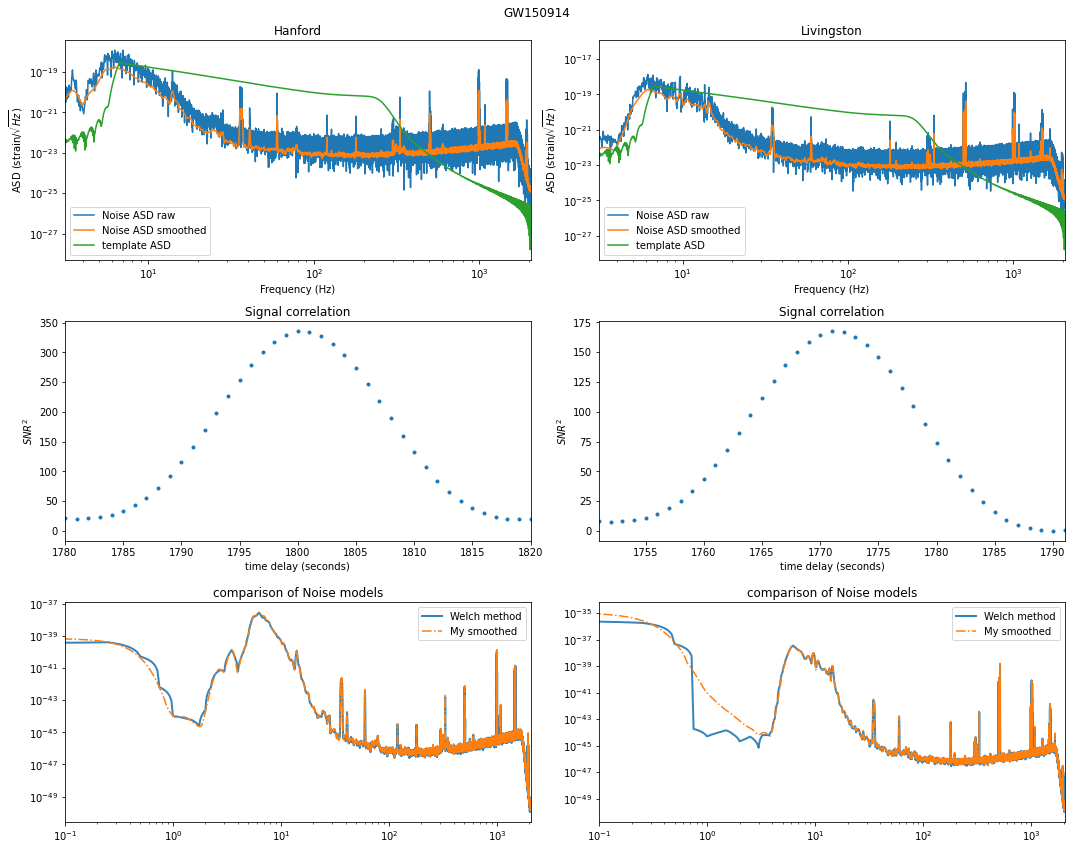

In [41]:
event = eventnames[0]
fig,ax = plt.subplots(3,2)
fig.set_size_inches(15,12)
fig.suptitle(event)
ax1 = ax[:,0]
ax2 = ax[:,1]
band = events[event]['fband']
ind1, snr1, snrfft1, analsnr1 = fit(events[event]['fn_H1'], events[event]['fn_template'], ax1, windows.tukey, args=(0.125,),\
                                    lowcutoff=band[0],highcutoff=band[1], corrcutoff=55000)
ind2, snr2, snrfft2, analsnr2 = fit(events[event]['fn_L1'], events[event]['fn_template'], ax2, windows.tukey, args=(0.125,), \
                                    lowcutoff=band[0], highcutoff=band[1], corrcutoff=55000, hanford=False)

print(f"SNR for event {event}: Hanford {snr1:4.1f}, Livingston {snr2:4.1f}")
print(f"SNR (LIGO method) for event {event}: Hanford {snrfft1:4.1f}, Livingston {snrfft2:4.1f}")
print(f"SNR (analytical) for event {event}: Hanford {analsnr1:4.1f}, Livingston {analsnr2:4.1f}")

# ratio1 = snr1/snr2
# ratio2 = snrfft1/snrfft2
# ratio3 = analsnr1/analsnr2



# print("ratios are:", ratio1, ratio2, ratio3)
combinedsnr = np.sqrt(snr1**2+snr2**2)
print(f"Combined SNR is {combinedsnr:4.1f}")
print(f"Time difference b/w wave at Hanford and Livingston: {timediff*1000:2.1f} ms")
timediff = np.abs(ind1-ind2)/4096
delx = c*timediff
del_theta = deldel_x/d * np.sqrt(1 - delx**2/d**2) *180/np.pi 
print("Uncertainty in position is ", del_theta, "degrees")


### Shown above is a zoomed in plot for SNR^2, used to determine the index where SNR^2 changes by ~ 1. All below plots show SNR, and not SNR^2, for full range.

for Hanford Half of filter weight comes till frequency bin 2749 correponding to frequency 85.90625 Hz
for Livingston Half of filter weight comes till frequency bin 3088 correponding to frequency 96.5 Hz
SNR for event LVT151012: Hanford  4.8, Livingston  4.3
SNR (LIGO method) for event LVT151012: Hanford  6.5, Livingston  5.9
SNR (analytical) for event LVT151012: Hanford  6.5, Livingston  5.9
1811 1814 indices
Combined SNR is  6.4
Time difference b/w wave at Hanford and Livingston: 0.7 ms
Uncertainty in position is  1.9729209035495696 degrees


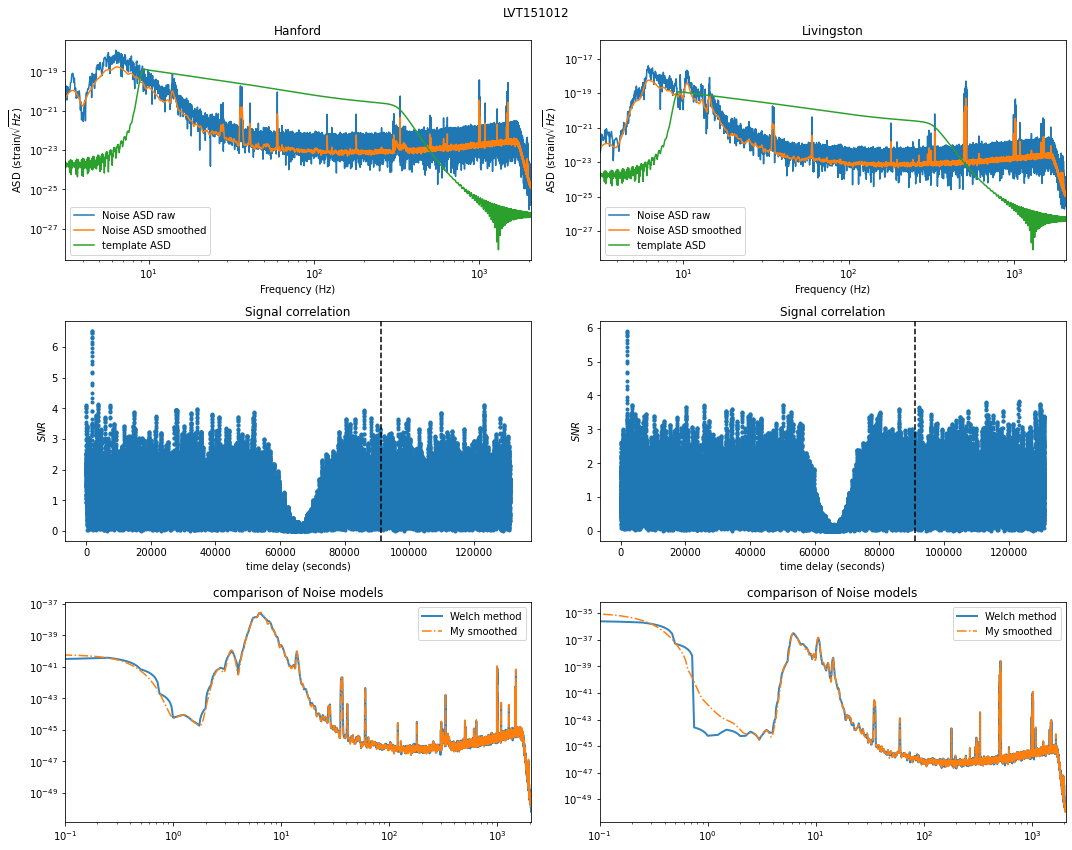

In [45]:
event = eventnames[1]
fig,ax = plt.subplots(3,2)
fig.set_size_inches(15,12)
fig.suptitle(event)
ax1 = ax[:,0]
ax2 = ax[:,1]
band = events[event]['fband']
ind1, snr1, snrfft1, analsnr1 = fit(events[event]['fn_H1'], events[event]['fn_template'], ax1, windows.tukey, args=(0.2,),\
                                    lowcutoff=band[0],highcutoff=band[1], corrcutoff=40000)
ind2, snr2, snrfft2, analsnr2 = fit(events[event]['fn_L1'], events[event]['fn_template'], ax2, windows.tukey, args=(0.2,), \
                                    lowcutoff=band[0], highcutoff=band[1], corrcutoff=40000, hanford=False)

print(f"SNR for event {event}: Hanford {snr1:4.1f}, Livingston {snr2:4.1f}")
print(f"SNR (LIGO method) for event {event}: Hanford {snrfft1:4.1f}, Livingston {snrfft2:4.1f}")
print(f"SNR (analytical) for event {event}: Hanford {analsnr1:4.1f}, Livingston {analsnr2:4.1f}")

# ratio1 = snr1/snr2
# ratio2 = snrfft1/snrfft2
# ratio3 = analsnr1/analsnr2
print(ind1, ind2, "indices")
timediff = np.abs(ind1-ind2)/4096
# print("ratios are:", ratio1, ratio2, ratio3)
combinedsnr = np.sqrt(snr1**2+snr2**2)
print(f"Combined SNR is {combinedsnr:4.1f}")
print(f"Time difference b/w wave at Hanford and Livingston: {timediff*1000:2.1f} ms")
timediff = np.abs(ind1-ind2)/4096
delx = c*timediff
del_theta = deldel_x/d * np.sqrt(1 - delx**2/d**2) *180/np.pi 
print("Uncertainty in position is ", del_theta, "degrees")


for Hanford Half of filter weight comes till frequency bin 3373 correponding to frequency 105.40625 Hz
for Livingston Half of filter weight comes till frequency bin 4496 correponding to frequency 140.5 Hz
SNR for event GW151226: Hanford  7.0, Livingston  5.2
SNR (LIGO method) for event GW151226: Hanford  9.7, Livingston  7.2
SNR (analytical) for event GW151226: Hanford  9.7, Livingston  7.2
Combined SNR is  8.8
Time difference b/w wave at Hanford and Livingston: 1.0 ms
Uncertainty in position is  1.9687785229711239 degrees


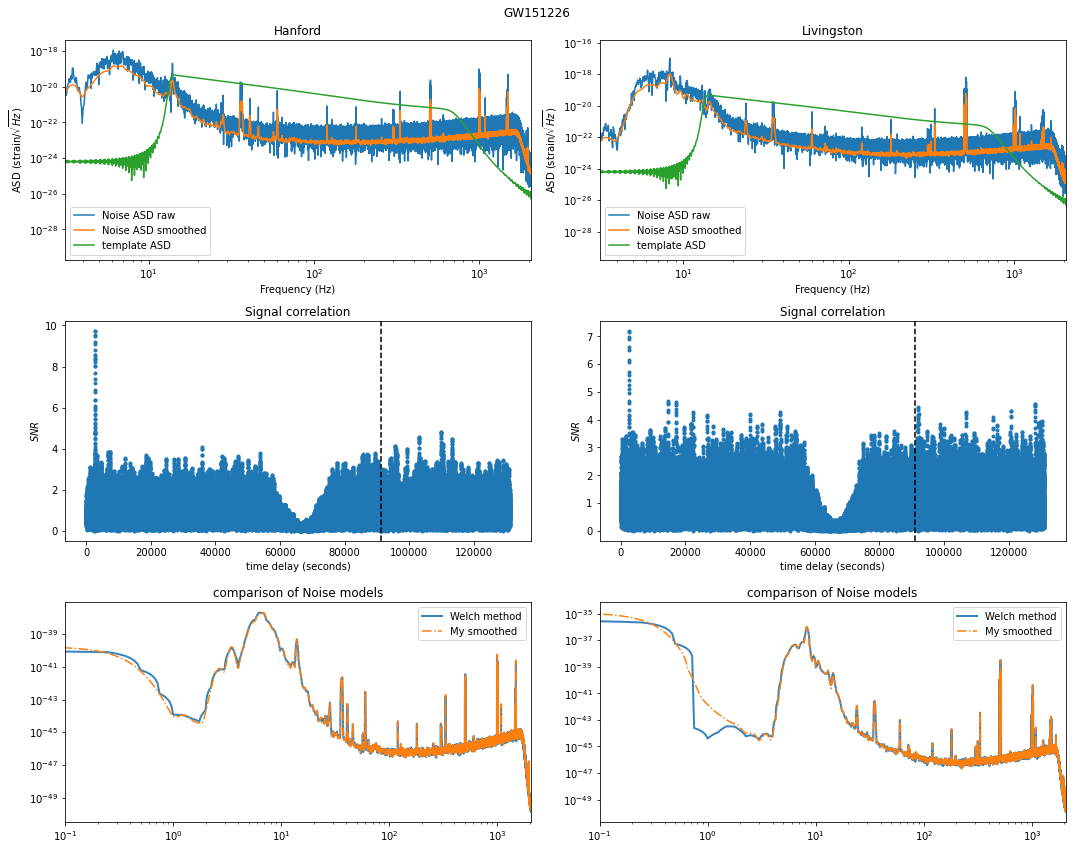

In [46]:
event = eventnames[2]
fig,ax = plt.subplots(3,2)
fig.set_size_inches(15,12)
fig.suptitle(event)
ax1 = ax[:,0]
ax2 = ax[:,1]
band = events[event]['fband']
ind1, snr1, snrfft1, analsnr1 = fit(events[event]['fn_H1'], events[event]['fn_template'], ax1, windows.tukey, args=(0.2,),\
                                    lowcutoff=band[0],highcutoff=band[1], corrcutoff=40000)
ind2, snr2, snrfft2, analsnr2 = fit(events[event]['fn_L1'], events[event]['fn_template'], ax2, windows.tukey, args=(0.2,), \
                                    lowcutoff=band[0], highcutoff=band[1], corrcutoff=40000, hanford=False)

print(f"SNR for event {event}: Hanford {snr1:4.1f}, Livingston {snr2:4.1f}")
print(f"SNR (LIGO method) for event {event}: Hanford {snrfft1:4.1f}, Livingston {snrfft2:4.1f}")
print(f"SNR (analytical) for event {event}: Hanford {analsnr1:4.1f}, Livingston {analsnr2:4.1f}")

# ratio1 = snr1/snr2
# ratio2 = snrfft1/snrfft2
# ratio3 = analsnr1/analsnr2

timediff = np.abs(ind1-ind2)/4096
# print("ratios are:", ratio1, ratio2, ratio3)
combinedsnr = np.sqrt(snr1**2+snr2**2)
print(f"Combined SNR is {combinedsnr:4.1f}")
print(f"Time difference b/w wave at Hanford and Livingston: {timediff*1000:2.1f} ms")
timediff = np.abs(ind1-ind2)/4096
delx = c*timediff
del_theta = deldel_x/d * np.sqrt(1 - delx**2/d**2) *180/np.pi 
print("Uncertainty in position is ", del_theta, "degrees")


for Hanford Half of filter weight comes till frequency bin 3014 correponding to frequency 94.1875 Hz
for Livingston Half of filter weight comes till frequency bin 2794 correponding to frequency 87.3125 Hz
SNR for event GW170104: Hanford  5.7, Livingston  6.9
SNR (LIGO method) for event GW170104: Hanford  7.8, Livingston  9.4
SNR (analytical) for event GW170104: Hanford  7.8, Livingston  9.4
Combined SNR is  8.9
Time difference b/w wave at Hanford and Livingston: 2.9 ms
Uncertainty in position is  1.8914331549052394 degrees


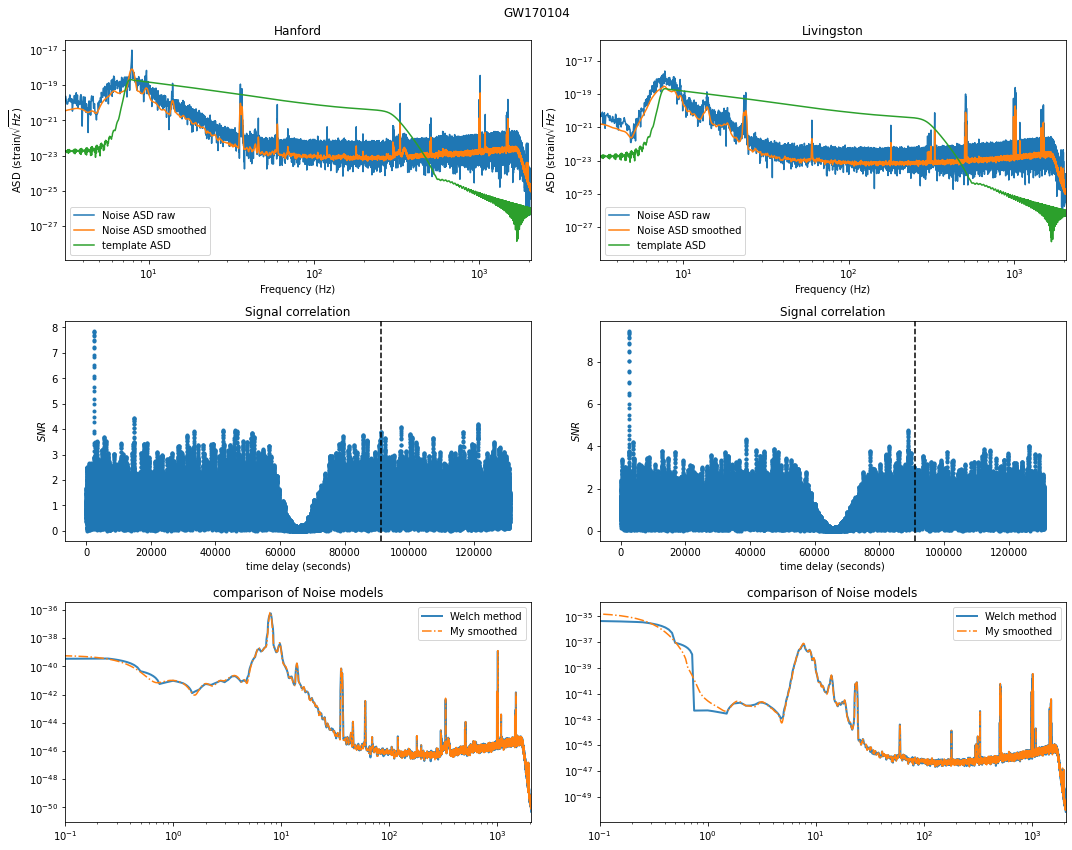

In [47]:
event = eventnames[3]
fig,ax = plt.subplots(3,2)
fig.set_size_inches(15,12)
fig.suptitle(event)
ax1 = ax[:,0]
ax2 = ax[:,1]
band = events[event]['fband']
ind1, snr1, snrfft1, analsnr1 = fit(events[event]['fn_H1'], events[event]['fn_template'], ax1, windows.tukey, args=(0.2,),\
                                    lowcutoff=band[0],highcutoff=band[1], corrcutoff=40000)
ind2, snr2, snrfft2, analsnr2 = fit(events[event]['fn_L1'], events[event]['fn_template'], ax2, windows.tukey, args=(0.2,), \
                                    lowcutoff=band[0], highcutoff=band[1], corrcutoff=40000, hanford=False)

print(f"SNR for event {event}: Hanford {snr1:4.1f}, Livingston {snr2:4.1f}")
print(f"SNR (LIGO method) for event {event}: Hanford {snrfft1:4.1f}, Livingston {snrfft2:4.1f}")
print(f"SNR (analytical) for event {event}: Hanford {analsnr1:4.1f}, Livingston {analsnr2:4.1f}")

# ratio1 = snr1/snr2
# ratio2 = snrfft1/snrfft2
# ratio3 = analsnr1/analsnr2

timediff = np.abs(ind1-ind2)/4096
# print("ratios are:", ratio1, ratio2, ratio3)
combinedsnr = np.sqrt(snr1**2+snr2**2)
print(f"Combined SNR is {combinedsnr:4.1f}")
print(f"Time difference b/w wave at Hanford and Livingston: {timediff*1000:2.1f} ms")
timediff = np.abs(ind1-ind2)/4096
delx = c*timediff
del_theta = deldel_x/d * np.sqrt(1 - delx**2/d**2) *180/np.pi 
print("Uncertainty in position is ", del_theta, "degrees")
